In [1]:
import os, sys
import numpy as np

from pathlib import Path

from astropy.io import fits, ascii
from astropy.table import Table, Column, vstack, hstack, join

from scipy import interpolate
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

sys.path.append("./py")
from utils import *

sys.path.append("/Users/aberti/Desktop/research")
from plotutils import get_corners, fig_labels, get_colors, plot_settings
plt.rcParams.update(**plot_settings)

plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.family"] = "STIXGeneral"

from params import BASEDIR, DATADIR, SIMDIR, H0, Om0
from params import get_boxsize, get_zsnap_data, get_sham_var_bins, get_abs_mag_lim, get_abs_mag_bins_clust

#-- bins for clustering (data and mocks)
from params import H0 #, bin_file_comoving


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/__init__.py:550: UserWarning: matplotlibrc text.usetex can not be used unless ghostscript-9.00 or later is installed on your system
  % gs_req)


<a class="anchor" id="outline"></a>

* [Load mock catalog](#load_mock)
* [Add scatter to colors](#color_scatter)
* [LRG flagging](#lrg)


# Set parameters

In [113]:
band   = "Mz"
zrange = (0.4,0.5)

print(band)
print(zrange)

zmag_lim = 20.7
sim_tag  = "mdpl2"
sham_tag = "vpeak"
d        = "south"
pimax    = 150
h        = H0/100.


z_snaps, snap_nums, snaps = get_zsnap_data(sim_tag)

vol_sim  = get_boxsize(sim_tag)**3
a_snaps = [snaps["scale"][snaps["snapnum"]==sn].data[0] for sn in snap_nums]

zmin, zmax  = zrange
cat_tag     = get_cat_tag(d,zrange)
abs_mag_lim = get_abs_mag_lim(zmin, band)
zsim        = np.array(z_snaps)[ np.round(z_snaps,1)==zmin ][0]
zsnap_tag   = get_zsnap_tag(zsim)
zmag_tag    = get_zmag_tag(zmag_lim)

MW1lim = get_abs_mag_lim(zmin,"MW1")
Mrlim  = get_abs_mag_lim(zmin,"Mr")
Mzlim  = get_abs_mag_lim(zmin,"Mz")
if band=="MW1":
    abs_mag_lim_tag = get_MW1_tag(MW1lim)
    abs_mag_range   = np.array((-24.5,-21.99))
    model_mag_range = np.array((-22.25,-25.35))
elif band=="Mr":
    abs_mag_lim_tag = get_Mr_tag(Mrlim)
    abs_mag_range   = np.array((-23,-20.49))
    model_mag_range = np.array((-20.8,-23.85))
elif band=="Mz":
    abs_mag_lim_tag = get_Mz_tag(Mzlim)
    abs_mag_range   = np.array((-23.75,-21.24))
    model_mag_range = np.array((-21.6,-24.6))
else:
    raise Exception()
    
abs_mag_bins_clust = get_abs_mag_bins_clust(zmin,band)[::-1]#[:-1]
    
# print(abs_mag_bins_clust)


Mz
(0.4, 0.5)


In [114]:
cs_tag = "csrand"

# fname = f"{BASEDIR}/data/hod_zsim{str(zsim).replace('.','p')}_{band}.npy"
fname = f"{BASEDIR}/data/hod_zsim{str(zsim).replace('.','p')}_{band}_{cs_tag}.npy"
print(fname)

this_hod_data = Table(np.load(fname))


/Users/aberti/Desktop/research/desi_lrg_sham/data/hod_zsim0p42531_Mz_csrand.npy


In [115]:
show = Table(data=[this_hod_data["mvir_mids"],
                  np.round(this_hod_data["mean_num_cen_opt_lrg_per_parent_mvir_bin"],2),
                  np.round(this_hod_data["mean_num_cen_IR_lrg_per_parent_mvir_bin"],2)],
             names=("Mvir", "Ncen_LRG-opt", "Ncen_LRG-IR"))

print(zmin, band, (cs_tag if "cs" in fname else ""))

show[show["Mvir"] > 13.9]


0.4 Mz csrand


Mvir,Ncen_LRG-opt,Ncen_LRG-IR
float64,float64,float64
13.95,0.82,0.79
14.05,0.85,0.83
14.15,0.86,0.85
14.25,0.88,0.85
14.35,0.89,0.89
14.45,0.88,0.89
14.55,0.9,0.86
14.65,0.89,0.88
14.75,0.84,0.84


<a class="anchor" id="load_mock"></a>
# Load mock

[BACK TO TOP](#outline)

[JUMP TO COLOR SCATTER](#color_scatter)


In [86]:
%%time

# f = f"{BASEDIR}/mocks/{sim_tag}/{sham_tag}/{d}/{zsnap_tag}_{abs_mag_lim_tag}"
f = f"{BASEDIR}/mocks/{sim_tag}/{sham_tag}/{d}/color_scatter/{zsnap_tag}_{abs_mag_lim_tag}"

# galcat_fname = f"{f}_galcat-hist-LRG.npy"
galcat_fname = f"{f}_galcat-LRG.npy"

print(galcat_fname)

cat = Table(np.load(galcat_fname))


/Users/aberti/Desktop/research/desi_lrg_sham/mocks/mdpl2/vpeak/south/color_scatter/zsnap0p62813_MW1limn23p15_galcat-LRG.npy
CPU times: user 763 ms, sys: 635 ms, total: 1.4 s
Wall time: 1.42 s


<a class="anchor" id="color_scatter"></a>
## Add scatter to colors

[BACK TO TOP](#outline)


In [87]:
if band=="Mz":
    if zmin==0.6:
        abs_mag_bins = np.concatenate( [np.round(np.arange(abs_mag_lim,-24.8,-0.05),2),
                                       [-24.8,-24.9,-25,-25.5,np.nanmin(cat[band])] ])
    elif (zmin==0.5) | (zmin==0.4):
        abs_mag_bins = np.concatenate( [np.round(np.arange(abs_mag_lim,-24.8,-0.05),2),
                                       [-24.8,-24.9,-25,np.nanmin(cat[band])] ])
elif band=="MW1":
    if zmin==0.6:
        abs_mag_bins = np.concatenate( [np.round(np.arange(abs_mag_lim,-26.1,-0.05),2),
                                       [-26.1,np.nanmin(cat[band])] ])
    elif zmin==0.5:
        abs_mag_bins = np.concatenate( [np.round(np.arange(abs_mag_lim,-25.8,-0.05),2),
                                       [-25.8,-26,np.nanmin(cat[band])] ])
    elif zmin==0.4:
        abs_mag_bins = np.concatenate( [np.round(np.arange(abs_mag_lim,-25.5,-0.05),2),
                                       [-25.5,-25.6,-25.7,np.nanmin(cat[band])] ])


In [88]:
colors_by_mag_bin = {}

for i in range(len(abs_mag_bins)-1):
    abs_mag_min, abs_mag_max = abs_mag_bins[i:i+2]
    abs_mag_bin_label = f"{abs_mag_min:.2f}_{abs_mag_max:.2f}".replace('.','p').replace('-','n')
    
    abs_mag_mask_model = (cat[band] < abs_mag_min) & (cat[band] >= abs_mag_max)
    
    colors_by_mag_bin[abs_mag_bin_label] = cat[abs_mag_mask_model]


In [90]:
%%time

#-- add scatter to assigned colors

color_cname = f"r-{band[1:]}"

sigc = "rand"
print(sigc)

for k in colors_by_mag_bin.keys():
    this_mag_bin_cat    = colors_by_mag_bin[k]
    this_mag_bin_colors = this_mag_bin_cat[color_cname]

    this_mag_bin_cat.sort(color_cname)

    colors_ranked = this_mag_bin_cat[color_cname].data.copy()

    colors_ranked_scattered = colors_ranked + np.random.normal(0, 3.0, len(colors_ranked))

    if "crs" in this_mag_bin_cat.colnames:
        this_mag_bin_cat.remove_column("crs")
    this_mag_bin_cat.add_column(Column(data=colors_ranked_scattered, name="crs"))

    this_mag_bin_cat.sort("crs")

    if f"{color_cname}_cs{sigc}" in this_mag_bin_cat.colnames:
        this_mag_bin_cat.remove_column(f"{color_cname}_cs{sigc}")

    this_mag_bin_cat.add_column(Column(data=colors_ranked, name=f"{color_cname}_cs{sigc}"))

    if "crs" in this_mag_bin_cat.colnames:
        this_mag_bin_cat.remove_column("crs")

test_cat = vstack(list(colors_by_mag_bin.values()))

len(test_cat)==len(cat)



rand
CPU times: user 3.75 s, sys: 250 ms, total: 3.99 s
Wall time: 4.02 s


True

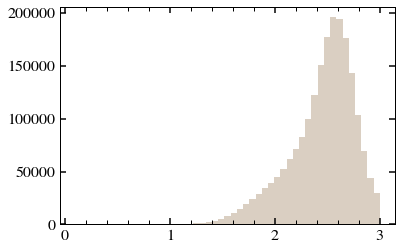

In [91]:
plt.hist(test_cat[f"r-{band[1:]}_csrand"], bins=np.linspace(0.1,3), alpha=0.2)
plt.hist(test_cat[f"r-{band[1:]}"], bins=np.linspace(0.1,3), alpha=0.2)
plt.show()


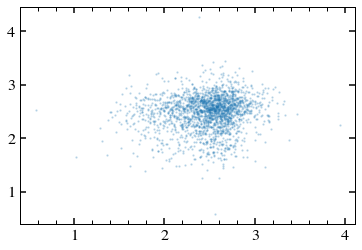

In [92]:
ds = 1000

# plt.scatter(test_cat[f"r-{band[1:]}"][::ds], test_cat["zstarve"][::ds], alpha=0.2, s=2)
# plt.scatter(test_cat[f"r-{band[1:]}_cs1p0"][::ds], test_cat["zstarve"][::ds], alpha=0.2, s=2)
# plt.scatter(test_cat[f"r-{band[1:]}_csrand"][::ds], test_cat["zstarve"][::ds], alpha=0.2, s=2)

plt.scatter(test_cat[f"r-{band[1:]}_csrand"][::ds], test_cat[f"r-{band[1:]}_cs1p0"][::ds], alpha=0.2, s=2)

plt.show()



<a class="anchor" id="lrg"></a>
# LRG flagging

[BACK TO TOP](#outline)


In [93]:
%%time

#-- add columns for LRG flagging
for c in (f"LRG_IR_cs{sigc}", f"LRG_opt_cs{sigc}"):
    if c in test_cat.colnames:
        test_cat.remove_column(c)
    test_cat.add_column(Column(np.zeros(len(test_cat), dtype=bool), name=c))

#-- get model magnitudes and colors for LRG flagging
model_mags    = test_cat[band]
model_mag_min = np.min(model_mags)
model_mag_max = np.max(model_mags)

model_colors    = test_cat[f"r-{band[1:]}_cs{sigc}"]
model_color_min = np.min(model_colors)
model_color_max = np.max(model_colors)


### OPTICAL LRG SELECTION ###

lrgfrac_opt_fname = f"{DATADIR}/stats/lrgfrac_optical-select_{band[1:]}-band_{cat_tag}.npy"
print(f"Loading {lrgfrac_opt_fname}...")

mag_bins_opt, color_bins_opt, H_lrg_opt, H_full_opt = np.load(lrgfrac_opt_fname, allow_pickle=True)

if model_mag_min < np.min(mag_bins_opt):
    mag_bins_opt[0] = np.floor(model_mag_min)
if model_mag_max > np.max(mag_bins_opt):
    mag_bins_opt[-1] = model_mag_max

if model_color_min < np.min(color_bins_opt):
    color_bins_opt[0] = np.floor(model_color_min)
if model_color_max > np.max(color_bins_opt):
    color_bins_opt[-1] = model_color_max

lrg_frac_opt = H_lrg_opt/H_full_opt

N_bins = (len(color_bins_opt)-1)*(len(mag_bins_opt)-1)

k = 1
test_cat[f"LRG_opt_cs{sigc}"] = False

for i in range(len(color_bins_opt)-1):
    color_mask = (model_colors > color_bins_opt[i]) & (model_colors <= color_bins_opt[i+1])
    for j in range(len(mag_bins_opt)-1):
        mag_mask = (model_mags > mag_bins_opt[j]) & (model_mags <= mag_bins_opt[j+1])
        bin_mask = mag_mask & color_mask
        N_mock   = len(test_cat[bin_mask])
        if N_mock > 0:
            indices = np.where(bin_mask)[0]            
            N_gal_opt = H_full_opt[i,j]
            N_lrg_opt = H_lrg_opt[i,j]

            targ_lrg_opt = 0
            if (N_lrg_opt > 0) & (N_gal_opt > 0):
                targ_lrg_opt = int(N_mock*lrg_frac_opt[i,j])

            if (targ_lrg_opt > 0):
                if (targ_lrg_opt < N_mock):
                    selected = indices[np.random.choice(len(indices), targ_lrg_opt, replace=False)]
                    test_cat[f"LRG_opt_cs{sigc}"][selected] = True
                else:
                    test_cat[f"LRG_opt_cs{sigc}"][indices] = True

            if (targ_lrg_opt > 0) and (k%100==0):
                print(f"{k}/{N_bins}\t{color_bins_opt[i]:.2f}\t{mag_bins_opt[j]:.2f}\t{N_mock}\t{targ_lrg_opt}")
        k += 1


### IR LRG SELECTION ###

lrgfrac_IR_fname = f"{DATADIR}/stats/lrgfrac_IR-select_{band[1:]}-band_{cat_tag}.npy"
print(f"Loading {lrgfrac_IR_fname}...")

mag_bins_IR, color_bins_IR, H_lrg_IR, H_full_IR = np.load(lrgfrac_IR_fname, allow_pickle=True)

if model_mag_min < np.min(mag_bins_IR):
    mag_bins_IR[0] = np.floor(model_mag_min)
if model_mag_max > np.max(mag_bins_IR):
    mag_bins_IR[-1] = model_mag_max

if model_color_min < np.min(color_bins_IR):
    color_bins_IR[0] = np.floor(model_color_min)
if model_color_max > np.max(color_bins_IR):
    color_bins_IR[-1] = model_color_max

lrg_frac_IR = H_lrg_IR/H_full_IR

N_bins = (len(color_bins_IR)-1)*(len(mag_bins_IR)-1)

k = 1
test_cat[f"LRG_IR_cs{sigc}"] = False

for i in range(len(color_bins_IR)-1):
    color_mask = (model_colors > color_bins_IR[i]) & (model_colors <= color_bins_IR[i+1])
    for j in range(len(mag_bins_IR)-1):
        mag_mask = (model_mags > mag_bins_IR[j]) & (model_mags <= mag_bins_IR[j+1])
        bin_mask = mag_mask & color_mask
        N_mock   = len(test_cat[bin_mask])
        if N_mock > 0:
            indices = np.where(bin_mask)[0]            
            N_gal_IR = H_full_IR[i,j]
            N_lrg_IR = H_lrg_IR[i,j]

            targ_lrg_IR = 0
            if (N_lrg_IR > 0) & (N_gal_IR > 0):
                targ_lrg_IR = int(N_mock*lrg_frac_IR[i,j])

            if (targ_lrg_IR > 0):
                if (targ_lrg_IR < N_mock):
                    selected = indices[np.random.choice(len(indices), targ_lrg_IR, replace=False)]
                    test_cat[f"LRG_IR_cs{sigc}"][selected] = True
                else:
                    test_cat[f"LRG_IR_cs{sigc}"][indices] = True

            if (targ_lrg_IR > 0) and (k%100==0):
                print(f"{k}/{N_bins}\t{color_bins_IR[i]:.2f}\t{mag_bins_IR[j]:.2f}\t{N_mock}\t{targ_lrg_IR}")
        k += 1


Loading /Users/aberti/Desktop/research/desi_lrg_sham/data/stats/lrgfrac_optical-select_W1-band_z0p60-0p70_south.npy...


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


500/9048	1.75	-24.25	168	15
600/9048	1.80	-23.60	1377	30
1000/9048	2.05	-25.35	3	3
1100/9048	2.10	-24.70	116	88
1200/9048	2.15	-24.05	1360	455
1300/9048	2.20	-23.40	4731	201
1600/9048	2.40	-25.80	1	1
1700/9048	2.45	-25.15	95	94
1800/9048	2.50	-24.50	1489	1394
1900/9048	2.55	-23.85	6121	4169
2300/9048	2.80	-25.60	32	32
2400/9048	2.85	-24.95	183	175
2500/9048	2.90	-24.30	710	552
2600/9048	2.95	-23.65	1617	8
3000/9048	3.20	-25.40	2	1
3100/9048	3.25	-24.75	32	21
3200/9048	3.30	-24.10	179	10
4900/9048	4.30	-26.10	1	1
Loading /Users/aberti/Desktop/research/desi_lrg_sham/data/stats/lrgfrac_IR-select_W1-band_z0p60-0p70_south.npy...


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in true_divide


800/8446	2.00	-24.40	292	285
1200/8446	2.25	-24.90	90	90
1300/8446	2.30	-24.00	2180	874
1600/8446	2.50	-25.40	43	43
1700/8446	2.55	-24.50	1622	1618
2000/8446	2.75	-25.90	7	7
2100/8446	2.80	-25.00	231	230
2200/8446	2.85	-24.10	1568	1514
2500/8446	3.05	-25.50	2	2
2600/8446	3.10	-24.60	85	80
2700/8446	3.15	-23.70	447	218
3000/8446	3.35	-25.10	8	7
3100/8446	3.40	-24.20	70	44
3500/8446	3.65	-24.70	8	5
4400/8446	4.20	-24.80	1	1
4800/8446	4.45	-25.30	1	1
CPU times: user 4min 11s, sys: 2.3 s, total: 4min 13s
Wall time: 4min 18s


In [94]:
print(len(test_cat[test_cat["LRG_IR"]==True]))
print(len(test_cat[test_cat["LRG_opt"]==True]))

for c in test_cat.colnames:
    if ("LRG_" in c) & ("_cs" in c):
        print(f"{c}\t{len(test_cat[test_cat[c]==True])}")
        
        

573171
655498
LRG_IR_cs0p05	573172
LRG_opt_cs0p05	655499
LRG_IR_cs0p1	573171
LRG_opt_cs0p1	655499
LRG_IR_cs0p2	573170
LRG_opt_cs0p2	655498
LRG_IR_cs0p4	573168
LRG_opt_cs0p4	655496
LRG_IR_cs0p6	573170
LRG_opt_cs0p6	655498
LRG_IR_cs0p8	573172
LRG_opt_cs0p8	655498
LRG_IR_cs1p0	573169
LRG_opt_cs1p0	655497
LRG_IR_csrand	573172
LRG_opt_csrand	655499


In [95]:
save_as = f"{BASEDIR}/mocks/{sim_tag}/{sham_tag}/{d}/color_scatter/{zsnap_tag}_{abs_mag_lim_tag}_galcat-LRG.npy"
print(f"Saving {save_as}...")

np.save(save_as, test_cat)


Saving /Users/aberti/Desktop/research/desi_lrg_sham/mocks/mdpl2/vpeak/south/color_scatter/zsnap0p62813_MW1limn23p15_galcat-LRG.npy...
